# Bin Packing Problem With Evolutionary Computations

In [2]:
from enum import Enum
from copy import copy, deepcopy
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from random import choices, randint, randrange, random, choice
import matplotlib.pyplot as plt
from math import sqrt
from tqdm import tqdm
import numpy as np

## 2D-Bin Packing Baseline - Greed Search with Heuristics

**Code** https://github.com/SebastianBitsch/bin-packing/blob/master/README.md

In [3]:
class PointType(Enum):
    BOTTOM_LEFT = 0
    BOTTOM_RIGHT = 1
    TOP_LEFT = 2
    TOP_RIGHT = 3

# Plot settings
figsize = (12,6)
placed_rect_color = 'lightblue'
unplaced_rect_color = 'grey'
ghost_rect_color = 'lightgrey'
edge_color = 'black'
alpha = 0.5

# Time settings
frametime = 0.02
starttime = 1
endtime = 10

all_rects = []
max_width = 0


def argmax(lst):
    return lst.index(max(lst))

def initialize_plot(C, rects = None, frame_time: float = 0.02, start_time: float = 4, end_time: float = 20, fig_size = (12,6)):
    global frametime, starttime, endtime
    global figsize, max_width
    global all_rects

    frametime = frame_time
    starttime = start_time
    endtime = end_time
    figsize = fig_size

    # Used for showing custom rects when late initializing plot
    if rects == None:
        all_rects = copy(C.unpacked_rects)
    else:
        all_rects = rects
    max_width = sum([r[0] for r in all_rects]) + 1 + len(all_rects)#TODO: Find better way of doing this


def plot_configuration(C, last_frame: bool):
    _, axs = plt.subplots(nrows=1, ncols=2,figsize=(12,6))

    # TODO: Find way to set this in init instead of every time plot is updated
    # Set the ticks for the main plot
    axs[0].set_xlim([0,C.size[0]])
    axs[0].set_ylim([0,C.size[1]])
    axs[0].set_xticks(range(0, C.size[0]+1, 5))
    axs[0].set_yticks(range(0, C.size[1]+1, 5))
    
    # Hide ticks for secondary ploty
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    axs[1].set_xlim([0,max_width])
    axs[1].set_ylim([0,max_width])


    # Draw the placed rects in main plot
    for rect in C.packed_rects:
        draw_rect(axs[0], rect.origin, rect.width, rect.height, placed_rect_color, edge_color, alpha)
    
    # Draw the possible ccoas main plot
    for rect in C.L:
        draw_rect(axs[0], rect.origin, rect.width, rect.height, ghost_rect_color, edge_color, 0.05)
    
    draw_points(axs[0], C.concave_corners)

    # Draw secondary plot
    draw_rects_overview(axs[1], all_rects, C.unpacked_rects)

    #final_time = endtime if last_frame else 0
    plt.show(block=False)
    #plt.pause(frametime + final_time)
    plt.close()


def draw_points(ax, corners: list[tuple], color='red', marker='x'):
    """
    Plot points given on the format [Point, Pointtype]
    """
    x = [i[0][0] for i in corners]
    y = [i[0][1] for i in corners]
    ax.scatter(x, y, c=color, marker=marker)


def draw_rects_overview(ax, all_rects: list, unplaced_rects: list):
    tallest = 0
    current_pos = (1,1)

    for w,h in all_rects:
        unplaced: bool = ((w,h) or (h,w)) in unplaced_rects
        color = unplaced_rect_color if unplaced else placed_rect_color
        tallest = max(tallest, h)
        
        draw_rect(ax, current_pos, w, h, background_color=color, edge_color=edge_color,alpha=alpha)
     
        current_pos = (current_pos[0] + w + 1, current_pos[1])
        
        if max_width < current_pos[0] + w + 1:
            current_pos = (1, current_pos[1] + tallest + 1)
            tallest = 0


def draw_rect(ax, origin, w, h, background_color, edge_color, alpha):
    box = Rectangle(origin, w, h, fc=background_color,ec=edge_color,alpha=alpha)
    ax.add_patch(box)

In [4]:
class Rect:

    def __init__(self, origin: tuple, width:float, height:float, origin_type: PointType = PointType.BOTTOM_LEFT, rotated:bool = False) -> None:
        """
        A container class and data structure for a rect representing a box to be packed. 
        Main functionality consists of wrapping and data and checking if rects overlap contain points etc.

        Parameters
        ----------
        origin, tuple
            a tuple of (x,y) coordinates containing the ogigin point of the box. Can be either of corners depending on the case

        width, float
            the width of the rect

        height, float
            the height of the rect

        origin_type, PointType
            an enum value determining which of the four corners is the origin point

        rotated, bool
            boolean value indicating whether the rect is rotated
        """        

        assert(0 < width and 0 < height)

        if rotated:
            temp = height
            height = width
            width = temp

        # Shift origin to bottom left corner depending on what type of point was given
        if origin_type == PointType.BOTTOM_LEFT:
            self.origin = origin
        if origin_type == PointType.TOP_LEFT:
            self.origin = (origin[0], origin[1] - height)
        if origin_type == PointType.BOTTOM_RIGHT:
            self.origin = (origin[0] - width, origin[1])
        if origin_type == PointType.TOP_RIGHT:
            self.origin = (origin[0] - width, origin[1] - height)
        
        self.width = width
        self.height = height
        self.rotated = rotated

        self.bottom = self.origin[1]
        self.top = self.origin[1]+self.height
        self.left = self.origin[0]
        self.right = self.origin[0]+self.width

        self.corner_bot_l = (self.left, self.bottom)
        self.corner_top_l = (self.left, self.top)
        self.corner_top_r = (self.right, self.top)
        self.corner_bot_r = (self.right, self.bottom)


    def __copy__(self):
        cls = self.__class__
        result = cls.__new__(cls)
        result.__dict__.update(self.__dict__)
        return result


    def __deepcopy__(self, memo):
        cls = self.__class__
        result = cls.__new__(cls)
        memo[id(self)] = result
        for k, v in self.__dict__.items():
            setattr(result, k, deepcopy(v, memo))
        return result


    @property
    def area(self) -> float:
        return self.width * self.height


    def contains(self, point: tuple) -> bool:
        """ Return whether the rect contains a given point (x,y) """
        return self.corner_bot_l[0] <= point[0] and self.corner_bot_l[1] <= point[1] and point[0] <= self.corner_top_r[0] and point[1] <= self.corner_top_r[1]


    def min_distance(self, other) -> float:
        """
        Returns the minumum distance between two Rects (AABBs), using an outer Rect method as described
        in: https://gamedev.stackexchange.com/questions/154036/efficient-minimum-distance-between-two-axis-aligned-squares
        """
        outer_left = min(self.left, other.left)
        outer_right = max(self.right, other.right)
        outer_bottom = min(self.bottom, other.bottom)
        outer_top = max(self.top, other.top)

        outer_width = outer_right - outer_left
        outer_height = outer_top - outer_bottom

        inner_width = max(0, outer_width - self.width - other.width)
        inner_height = max(0, outer_height - self.height - other.height)

        # TODO: Might be able to remove a sqrt here, not sure
        return sqrt(inner_width**2 + inner_height**2)


    def overlaps(self, other) -> bool:
        """
        Returns wether two Rects overlap
        """
        if self.right <= other.left or other.right <= self.left:
            return False
        if self.top <= other.bottom or other.top <= self.bottom:
            return False
        return True
        

    def __iter__(self):
        """
        Iterate through rectangle corners
        """
        yield self.corner_bot_l
        yield self.corner_top_l
        yield self.corner_top_r
        yield self.corner_bot_r

    def __repr__(self):
        return "R = (({}, {}), w={}, h={},r={})".format(self.origin[0], self.origin[1], self.width, self.height,self.rotated)

In [5]:
class Configuration:

    # The amount to look in each direction when determining if a corner is concave
    eps = 0.001

    def __init__(self, size: tuple, unpacked_rects: list, packed_rects: list[Rect] = [], enable_plotting: bool = False) -> None:
        self.size = size
        
        self.unpacked_rects = unpacked_rects
        self.packed_rects = packed_rects
        self.plotting = enable_plotting
        
        self.generate_L()

        if self.plotting:
            initialize_plot(self)
            

    def __copy__(self):
        cls = self.__class__
        result = cls.__new__(cls)
        result.__dict__.update(self.__dict__)
        return result

    def __deepcopy__(self, memo):
        cls = self.__class__
        result = cls.__new__(cls)
        memo[id(self)] = result
        for k, v in self.__dict__.items():
            setattr(result, k, deepcopy(v, memo))
        return result

    def enable_plotting(self):
        self.plotting = False

    # TODO: Can be alot faster by taking the most recently placed rect as input - and only generating 
    #       new ccoas for points that are contained in the new rect
    def generate_L(self):
        """
        A function that takes the current configuration, all the remaining rects and returns all
        possible CCOAs that can be fitted to the configuration
        Parameters
        ----------
        C: Configuration, required
            The current configuration
        
        remaining_rects: list[tuple], required:
            The dimensions of the rects yet to be packed. On the format: (w,h)
        """
        # 1. concave corners
        self.concave_corners = self.get_concave_corners()

        # 2. generate ccoas for every rect
        ccoas: list[Rect] = []
        for x, y in self.unpacked_rects:
            for corner, type in self.concave_corners:
                for rotated in [False, True]:
                    ccoa = Rect(corner, x, y, type, rotated)

                    # 3. Add if it fits
                    if not self.fits(ccoa):
                        continue
                    ccoas.append(ccoa)

        self.L = ccoas

    def get_concave_corners(self) -> list[tuple[tuple,PointType]]:
        concave_corners: list[tuple(tuple,PointType)] = []

        for corner in self.get_all_corners():
            corner_type = self.get_corner_type(corner)
            if corner_type:
                concave_corners.append((corner,corner_type))

        return concave_corners

    def get_corner_type(self, p: tuple) -> bool:
        checks = self.check_boundaries(p)
        if sum(checks) == 3:
            index = [i for i, x in enumerate(checks) if not x][0]
            return PointType(index)
        return None

    def check_boundaries(self, p: tuple):
        return [
            self.contains((p[0]+self.eps, p[1]+self.eps)),
            self.contains((p[0]-self.eps, p[1]+self.eps)),
            self.contains((p[0]+self.eps, p[1]-self.eps)),
            self.contains((p[0]-self.eps, p[1]-self.eps))
        ]

    def contains(self, point: tuple) -> bool:
        # Return true if point is out of bounds
        if point[0] <= 0 or point[1] <= 0 or self.size[0] <= point[0] or self.size[1] <= point[1]:
            return True
        
        # Check if any of the packed rects contain the point
        for r in self.packed_rects:
            if r.contains(point):
                return True
        return False


    def fits(self, ccoa: Rect) -> bool:
        """
        Returns true if a given ccoa fits into the configuration without overlapping any of the rects
        or being out of bounds
        """
        # Check if the ccoa is out of bounds in any way
        if ccoa.origin[0] < 0 or ccoa.origin[1] < 0 or self.size[0] < ccoa.origin[0] + ccoa.width or self.size[1] < ccoa.origin[1] + ccoa.height:
            return False
        
        # Check if the rect overlaps any of the already packed rects
        for rect in self.packed_rects:
            if ccoa.overlaps(rect):
                return False
        return True


    def place_rect(self, rect: Rect) -> None:
        # Add rect to packed rects
        self.packed_rects.append(rect)

        # Remove the rect from unpacked rects
        if (rect.width,rect.height) in self.unpacked_rects:
            self.unpacked_rects.remove((rect.width,rect.height))
        elif (rect.height, rect.width) in self.unpacked_rects:
            self.unpacked_rects.remove((rect.height, rect.width))

        self.generate_L() # TODO: Do somehing like passing the just placed rect for more efficiency

        # Create plot
        if self.plotting:
            plot_configuration(self, self.is_successful())


    def density(self) -> float:
        """
        Return the percentage of total container area filled by packed rects
        """
        total_area = self.size[0] * self.size[1]
        occupied_area = sum([x.area for x in self.packed_rects])

        return occupied_area/total_area


    def get_all_corners(self) -> list[tuple]:
        """
        Returns a set of all unique points in the container
        """

        # The container corners
        corners = [(0,0), (0,self.size[1]), (self.size[0],0), self.size]

        # Get corners for every rect
        for rect in self.packed_rects:
            corners += [rect.corner_bot_l, rect.corner_bot_r, rect.corner_top_l, rect.corner_top_r]
        return list(set(corners))


    def is_successful(self) -> bool:
        return len(self.unpacked_rects) == 0

In [6]:
class BinPacker:

    def __init__(self, configuration: Configuration) -> None:
        self.C = configuration

    def _degree(self, i:Rect, C: Configuration) -> float:
        d_mins = [i.min_distance(m) for m in C.packed_rects]
        
        # Add the distances to the borders
        d_mins += [i.bottom, i.left, C.size[1] - i.top, C.size[0] - i.right]

        # Remove two smallest elements, which will be 0 - the two imediate neighbours
        assert(min(d_mins) == 0)
        d_mins.remove(min(d_mins))
        assert(min(d_mins) == 0)
        d_mins.remove(min(d_mins))

        return 1 - (min(d_mins) /((i.width + i.height)/2))


    def _A0(self, C: Configuration):
        while C.L:

            degrees = [self._degree(ccoa, C) for ccoa in C.L]
            best = argmax(degrees)

            C.place_rect(C.L[best])
        return C


    def _BenefitA1(self, ccoa: Rect, Cx: Configuration):

        Cx.place_rect(ccoa)

        Cx = self._A0(Cx)

        if Cx.is_successful():
            return Cx
        else:
            return Cx.density()


    def PackConfiguration(self, C: Configuration):
        """ The method called A1 in the paper """

        while C.L:
            max_benefit = 0
            max_benefit_ccoa = None
            
            for ccoa in C.L:
                d = self._BenefitA1(ccoa, deepcopy(C))
                if type(d) is Configuration:
                    print("Found successful configuration")
                    return d
                else:
                    if max_benefit < d:
                        max_benefit = d
                        max_benefit_ccoa = ccoa

            print(f"Placed {max_benefit_ccoa}, {len(C.unpacked_rects)} rects remaining")
            C.place_rect(max_benefit_ccoa)

        if C.is_successful():
            print("Found successful configuration")
        else:
            print("Stopped with failure")
            print(f"Rects remaining: {C.unpacked_rects}")
        return C

In [11]:
cat1_p1 = [(2,12),(7,12),(8,6),(3,6),(3,5),(5,5),(3,12),(3,7),(5,7),(2,6),(3,2),(4,2),(3,4),(4,4),(9,2),(11,2)]
cat3_p1 = [(7,5),(14,5),(14,8),(4,8),(21,13),(7,11),(14,11),(14,5),(4,5),(18,3),(21,3),(17,11),(4,11),(7,4),
           (5,4),(6,7),(18,5),(3,5),(7,3),(5,3),(18,4),(3,4),(12,2),(6,2),(18,5),(21,5),(17,3),(4,3)]

def main():

    # Parameters
    rects = cat1_p1
    plotting = False
    container_size = (20,20)


    C = Configuration(size=container_size, unpacked_rects=copy(rects), enable_plotting=plotting)
    packer = BinPacker(C)

    # For profiling     
    # cProfile.run('C = packer.PackConfiguration(C)', sort="time")
    C = packer.PackConfiguration(C)

    # Show final configuration
    if not plotting:
        initialize_plot(C, rects, 5)
        plot_configuration(C, last_frame=True)

Found successful configuration


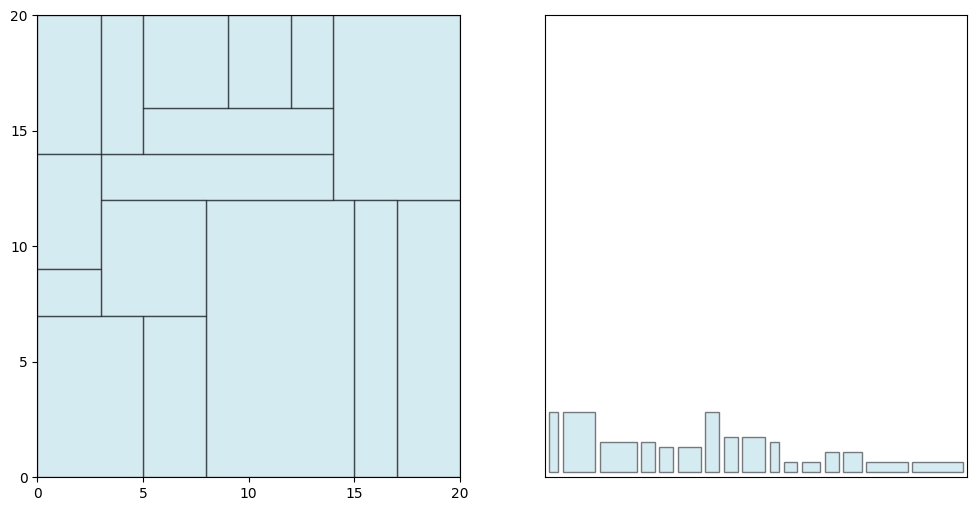

In [12]:
main()

## Genetic algorithms from scratch

**NEED**
- configuration to represent an individual(solution)
- Mutation function
- Crossover function
- Selection
- Fitness function

In [39]:
BIN_WIDTH = 20
BIN_HEIGHT = 20


def generate_items(n):
    return [(randrange(1,BIN_WIDTH//3), randrange(1,BIN_HEIGHT//3)) for _ in range(n)]

#items = [(2,12),(7,12),(8,6),(3,6),(3,5),(5,5),(3,12),(3,7),(5,7),(2,6),(3,2),(4,2),(3,4),(4,4),(9,2),(11,2)]
items = [(2,12),(7,12),(8,6),(3,6),(3,5),(5,5),(3,12),(3,7),(5,7),(2,6),(3,2),(4,2)]

In [26]:
## utility functions
def get_overlap_area(pos_a, dim_a, pos_b, dim_b):
    overlap_x = max(0, min(pos_a[0] + dim_a[0], pos_b[0] + dim_b[0]) - max(pos_a[0], pos_b[0]))
    overlap_y = max(0, min(pos_a[1] + dim_a[1], pos_b[1] + dim_b[1]) - max(pos_a[1], pos_b[1]))
    return overlap_x * overlap_y

In [36]:
def generate_genome(items):
    candidate = []

    for obj in items:
        # Each object has x, y, width, height as decision variables
        x = randint(0, BIN_WIDTH - obj[0])
        y = randint(0, BIN_HEIGHT - obj[1])
        candidate.append((x, y))
    return candidate

def generate_population(size: int, items):
    return [generate_genome(items) for _ in range(size)]

## Fitness using overlapped area (Minimization problem)
#def fitness(genome, items): 
#    
#    overlapped_area = 0
#
#    for i in range(len(items)):
#        for j in range(i+1, len(items)):
#            overlapped_area += get_overlap_area(genome[i],items[i], genome[j],items[j]) ## Penalty for overlap
#    return overlapped_area

## Fitness using Matrix vectorization (Maximization problem)
def fitness(genome, items):
    sol_space = np.zeros((BIN_WIDTH, BIN_HEIGHT), dtype=np.int32)

    for gene, item in zip(genome, items):
        sol_space[gene[0]:gene[0]+item[0], gene[1]:gene[1]+item[1]] += 1

    good_pos = np.where(sol_space == 1) ## the more space they occupy the better the fitness
    good_fit = len(sol_space[good_pos])

    bad_pos = np.where(sol_space > 1) ## penalty function for overlapped area
    bad_fit = len(sol_space[bad_pos])

    return (good_fit - bad_fit) 

## Selection for Minimization
#def selection_pair(population, n_parents : int = 2):
#    fitnesses = [fitness(genome, items) for genome in population]
#    worst_fitness = max(fitnesses)
#    return choices(population=population,
#                   weights=[worst_fitness - fit for fit in fitnesses],
#                   k=n_parents)

## Selection for Maximization
def selection_pair(population, n_parents : int = 2): ## Roulette-wheel selection
    return choices(population=population,
                   weights=[fitness(genome, items) for genome in population],
                   k=n_parents)

def single_point_crossover(a, b):
    assert len(a) == len(b), 'Genomes must have the same length'

    length = len(a)
    if length < 2:
        return a, b
    
    p = randint(1, length - 1)
    return a[0:p] + b[p:], b[0:p] + a[p:]

def mutation(genome, items, num: int = 1, probability: float = 0.5):
    for _ in range(num):
        index = randrange(len(genome))
        if random() <= probability:
            x = randint(0, BIN_WIDTH - items[index][0])
            y = randint(0, BIN_HEIGHT - items[index][1])
            genome[index] = (x, y)
    return genome

def run_evolution(pop_size=100, generation_limit: int = 100, num_mutation = 1, mutation_probability=0.5, n_elites=2):
    
    fitness_limit = sum([item[0]*item[1] for item in items])

    population = generate_population(pop_size, items=items)
    best_fitnesses = []
    worst_fitnesses = []

    for i in tqdm(range(generation_limit)):
        population = sorted(population, key=lambda genome: fitness(genome, items), reverse=True)

        best_fitnesses.append(fitness(population[0], items))
        worst_fitnesses.append(fitness(population[-1], items))
        
        if fitness(population[0], items) == fitness_limit:
            print('All items can fit perfectly in the bin!')
            break
        
        next_generation = population[0:n_elites] ## Elitism

        for j in range(int(len(population) /2) - (n_elites//2)):
            parents = selection_pair(population)
            offspring_a, offspring_b = single_point_crossover(parents[0], parents[1])
            offspring_a = mutation(offspring_a, items, num=num_mutation, probability=mutation_probability)
            offspring_b = mutation(offspring_b, items, num=num_mutation, probability=mutation_probability)
            next_generation += [offspring_a, offspring_b]
        
        population = next_generation

    population = sorted(population, key=lambda genome: fitness(genome, items), reverse=True)
    best_fitness = fitness(population[0], items)
    best_fitnesses.append(best_fitness)
    worst_fitnesses.append(fitness(population[-1], items))
    
    return population, i, best_fitness, best_fitnesses, worst_fitnesses, fitness_limit

In [43]:
## print solution

# Plot settings
figsize = (6,6)
rect_color = 'lightblue'
edge_color = 'black'
alpha = 0.5

def plot_configuration(configuration, items):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)

    # Set the ticks for the main plot
    ax.set_xlim([0,BIN_WIDTH])
    ax.set_ylim([0,BIN_HEIGHT])
    ax.set_xticks(range(0, BIN_WIDTH+1, 5))
    ax.set_yticks(range(0, BIN_HEIGHT+1, 5))

    # Draw the placed rects in main plot
    for position, item in zip(configuration, items):
        box = Rectangle(position, item[0], item[1], fc=rect_color, ec=edge_color, alpha=alpha)
        ax.add_patch(box)

    plt.show(block=False)
    plt.title('Best Configuration')
    plt.close()


def plot_fitness(best_fit, worst_fit, n_gen, fit_lim):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.plot(best_fit, label='Best fitness')
    ax.plot(worst_fit, label='Worst fitness')
    ax.hlines(y=fit_lim, xmin=0, xmax=n_gen, colors='black', label='Optimal', linestyles='--')
    ax.set_xlim([0, n_gen])
    #ax.set_ylim([0, fit_lim])
    ax.legend()
    plt.xlabel('Generations')
    plt.ylabel('Fitness')
    plt.title('Fitness Evolution')
    plt.show()

 55%|█████▍    | 137/250 [00:23<00:19,  5.82it/s]


All items can fit perfectly in the bin!
number of generations:  137
items:  [(2, 12), (7, 12), (8, 6), (3, 6), (3, 5), (5, 5), (3, 12), (3, 7), (5, 7), (2, 6), (3, 2), (4, 2)]
best solution:  [(8, 7), (0, 1), (10, 14), (5, 14), (17, 0), (0, 15), (14, 2), (17, 7), (7, 0), (12, 2), (11, 9), (1, 13)]
maximum fitness =  332
best fitness:  332


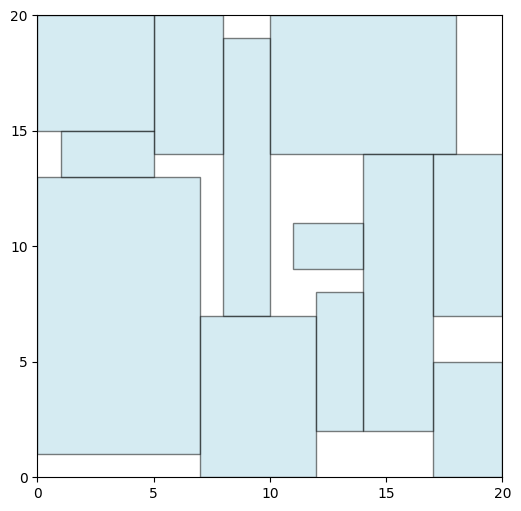

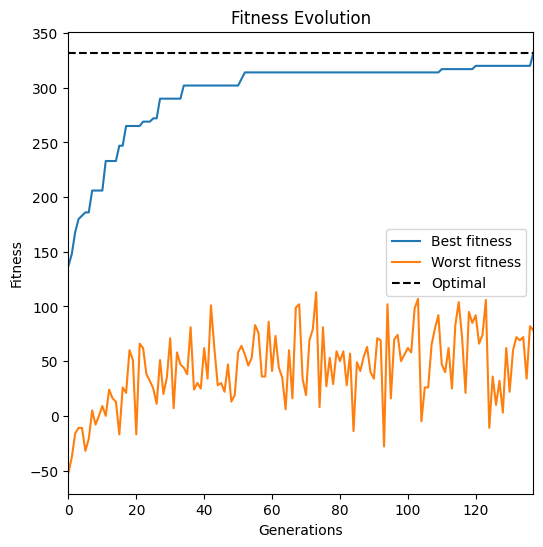

In [44]:
population, generations, fit, best_fits, worst_fits, fit_lim = run_evolution(generation_limit=250, num_mutation=1, mutation_probability=0.5, n_elites=4)

print('number of generations: ', generations)
print('items: ', items)
print('best solution: ', population[0])
print('maximum fitness = ',fit_lim)
print('best fitness: ', fit)
plot_configuration(population[0], items)
plot_fitness(best_fits, worst_fits, generations, fit_lim)

 46%|████▌     | 69/150 [00:12<00:14,  5.52it/s]


All items can fit perfectly in the bin!


100%|██████████| 150/150 [00:41<00:00,  3.58it/s]


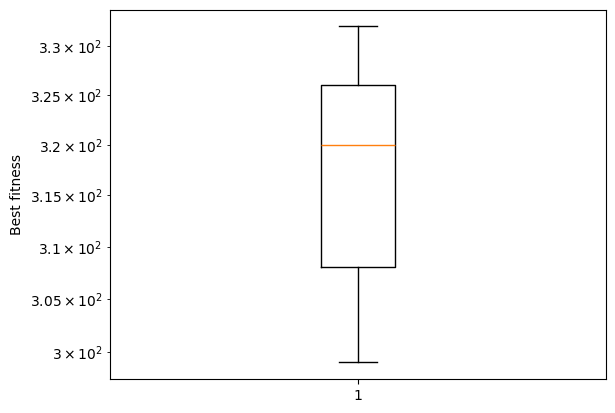

In [47]:
## Multiple runs
n_runs = 20
best_fitnesses = []
for _ in range(n_runs):
    _,_,best_fitness,_,_,_ = run_evolution(generation_limit=150, num_mutation=1, mutation_probability=0.5, n_elites=2)
    best_fitnesses.append(best_fitness)


fig = plt.figure('GA (best fitness)')
ax = fig.gca()
ax.boxplot([best_fitnesses], notch=False)
#ax.set_xticklabels(['Mutation only'])
ax.set_yscale('log')
#ax.set_xlabel('Condition')
ax.set_ylabel('Best fitness')
plt.show()

 79%|███████▉  | 79/100 [00:13<00:03,  5.76it/s]


All items can fit perfectly in the bin!


100%|██████████| 100/100 [00:17<00:00,  5.72it/s]


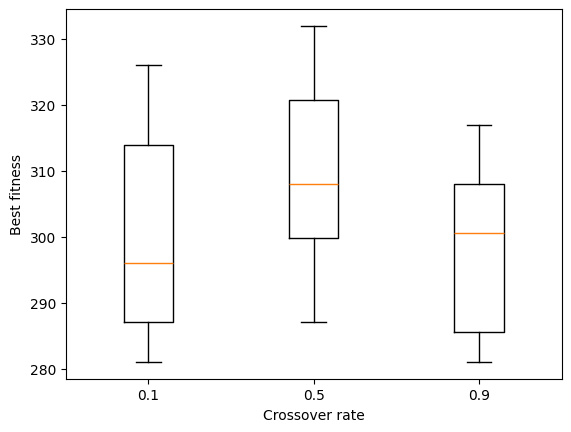

In [48]:
## Fine-tuning mutation
n_runs = 10
mutation_rates = [0.1, 0.5, 0.9] # mutation rates

best_fitnesses = []
for mutation_rate in mutation_rates:
    fitnesses_each_mutation = []
    for _ in range(n_runs):
        _,_,best_fitness,_,_,_ = run_evolution(generation_limit=100, num_mutation=1, mutation_probability=mutation_rate, n_elites=2)
        fitnesses_each_mutation.append(best_fitness)
    best_fitnesses.append(fitnesses_each_mutation)

fig = plt.figure('GA (best fitness)')
ax = fig.gca()
ax.boxplot(best_fitnesses,notch=False)
ax.set_xticklabels(mutation_rates)
ax.set_xlabel('Mutation rate')
ax.set_ylabel('Best fitness')
plt.show()

## 3D Bin Packing - Greed Search

## 3D Bin Packing - Genetic Algorithms

In [49]:
BOX_WIDTH = 20
BOX_HEIGHT = 20
BOX_LENGTH = 20


def generate_items_3d(n):
    return [(randrange(1,BOX_WIDTH//3), randrange(1,BOX_HEIGHT//3), randrange(1,BOX_LENGTH//3)) for _ in range(n)]

items = [(2,12,3),(7,12,4),(8,6,6),(3,6,2),(3,5,5),(5,5,3),(3,12,4),(3,7,4),(5,7,8),(2,6,9),(3,2,11),(4,2,7),(7,8,2),(10,3,8),(7,12,4),(8,6,6),(3,6,2)]

In [50]:
def generate_genome(items):
    candidate = []

    for obj in items:
        # Each object has x, y, width, height as decision variables
        x = randint(0, BOX_WIDTH - obj[0])
        y = randint(0, BOX_HEIGHT - obj[1])
        z = randint(0, BOX_LENGTH - obj[2])
        candidate.append((x, y, z))
    return candidate

def generate_population(size: int, items):
    return [generate_genome(items) for _ in range(size)]



## Fitness using Matrix vectorization (Maximization problem)
def fitness(genome, items):
    sol_space = np.zeros((BOX_WIDTH, BOX_HEIGHT, BOX_LENGTH), dtype=np.int32)

    for gene, item in zip(genome, items):
        sol_space[gene[0]:gene[0]+item[0], gene[1]:gene[1]+item[1], gene[2]:gene[2]+item[2]] += 1

    good_pos = np.where(sol_space == 1) ## the more space they occupy the better the fitness
    good_fit = len(sol_space[good_pos])

    bad_pos = np.where(sol_space > 1) ## penalty function for overlapped area
    bad_fit = len(sol_space[bad_pos])

    return (good_fit - bad_fit) 

## Selection for Maximization
def selection_pair(population, n_parents : int = 2):
    return choices(population=population, weights=[fitness(genome, items) for genome in population], k=n_parents)

def single_point_crossover(a, b):
    assert len(a) == len(b), 'Genomes must have the same length'

    length = len(a)
    if length < 2:
        return a, b
    
    p = randint(1, length - 1)
    return a[0:p] + b[p:], b[0:p] + a[p:]

def mutation(genome, items, num: int = 1, probability: float = 0.5):
    for _ in range(num):
        index = randrange(len(genome))
        if random() <= probability:
            x = randint(0, BOX_WIDTH - items[index][0])
            y = randint(0, BOX_HEIGHT - items[index][1])
            z = randint(0, BOX_LENGTH - items[index][2])
            genome[index] = (x, y, z)
    return genome

def run_evolution(pop_size=100, generation_limit: int = 100, num_mutation = 1, mutation_probability=0.5):
    
    fitness_limit = sum([item[0]*item[1]*item[2] for item in items])

    population = generate_population(pop_size, items=items)
    best_fitnesses, worst_fitnesses = [], []

    for i in tqdm(range(generation_limit)):
        population = sorted(population, key=lambda genome: fitness(genome, items), reverse=True)
        best_fitnesses.append(fitness(population[0], items))
        worst_fitnesses.append(fitness(population[-1], items))
        
        if fitness(population[0], items) == fitness_limit:
            print('All items can fit perfectly in the box!')
            break
        
        next_generation = population[0:2] ## Elitism

        for j in range(int(len(population) /2) - 1):
            parents = selection_pair(population)
            offspring_a, offspring_b = single_point_crossover(parents[0], parents[1])
            offspring_a = mutation(offspring_a, items, num=num_mutation, probability=mutation_probability)
            offspring_b = mutation(offspring_b, items, num=num_mutation, probability=mutation_probability)
            next_generation += [offspring_a, offspring_b]
        
        population = next_generation

    population = sorted(population, key=lambda genome: fitness(genome, items), reverse=True)
    best_fitness = fitness(population[0], items)
    best_fitnesses.append(best_fitness)
    worst_fitnesses.append(fitness(population[-1], items))
    
    return population, i, best_fitness, best_fitnesses, worst_fitnesses, fitness_limit

In [51]:
from mpl_toolkits.mplot3d import Axes3D

# Plot settings
figsize = (6,6)
rect_color = 'lightblue'
edge_color = 'black'
alpha = 0.8

def plot_boxes(ax, boxes_pos, boxes_dim):
    for pos, dim in zip(boxes_pos, boxes_dim):
        x, y, z = pos
        dx, dy, dz = dim
        ax.bar3d(x, y, z, dx, dy, dz, shade=True, color='lightblue', edgecolors=edge_color, alpha=alpha)
        
## Plot configuration
def plot_configuration_3d(configuration, items):


    # Create the 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Set plot limits
    ax.set_xlim([0, BOX_WIDTH])
    ax.set_ylim([0, BOX_HEIGHT])
    ax.set_zlim([0, BOX_LENGTH])

    # Plot the boxes
    plot_boxes(ax, configuration, items)

    # Set labels
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.set_title('3D Bin Packing Solution')

    # Show the plot
    plt.show()

 70%|███████   | 141/200 [00:19<00:08,  7.34it/s]


All items can fit perfectly in the box!
number of generations:  141
items:  [(2, 12, 3), (7, 12, 4), (8, 6, 6), (3, 6, 2), (3, 5, 5), (5, 5, 3), (3, 12, 4), (3, 7, 4), (5, 7, 8), (2, 6, 9), (3, 2, 11), (4, 2, 7), (7, 8, 2), (10, 3, 8), (7, 12, 4), (8, 6, 6), (3, 6, 2)]
best solution:  [(18, 4, 5), (0, 5, 10), (1, 2, 0), (11, 0, 15), (6, 14, 5), (9, 13, 4), (11, 3, 10), (1, 10, 4), (11, 4, 2), (15, 11, 10), (15, 2, 9), (15, 0, 2), (0, 0, 15), (0, 17, 11), (3, 8, 0), (3, 11, 14), (8, 4, 7)]
best fitness:  2632
maximum fitness =  2632


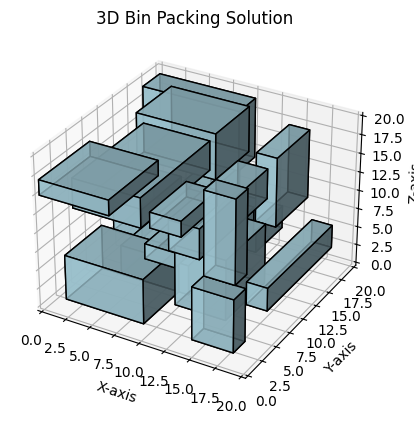

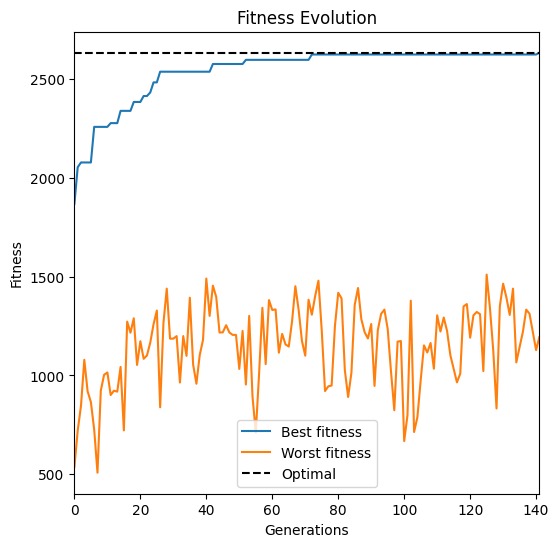

In [52]:
population, generations, fit, best_fits, worst_fits, fit_lim = run_evolution(pop_size=50, generation_limit=200, num_mutation=2, mutation_probability=0.5)

print('number of generations: ', generations)
print('items: ', items)
print('best solution: ', population[0])
print('best fitness: ', fit)
print('maximum fitness = ',fit_lim)
plot_configuration_3d(population[0], items)
plot_fitness(best_fits, worst_fits, generations, fit_lim)

In [23]:
import plotly.graph_objects as go

def plot_boxes_interactive(fig, boxes_pos, boxes_dim):
    for pos, dim in zip(boxes_pos, boxes_dim):
        x, y, z = pos
        dx, dy, dz = dim

        #colors = ["#"+''.join([choice('0123456789ABCDEF') for j in range(6)]) for i in range(2)]
        color = "#"+''.join([choice('0123456789ABCDEF') for j in range(6)])
        
        fig.add_trace(go.Mesh3d(x=[x, x, x+dx, x+dx, x, x, x+dx, x+dx],
                                y=[y, y+dy, y+dy, y, y, y+dy, y+dy, y],
                                z=[z, z, z, z, z+dz, z+dz, z+dz, z+dz],
                                #colorscale=[[0, colors[0]],[1, colors[1]]],
                                # Intensity of each vertex, which will be interpolated and color-coded
                                #intensity = np.linspace(0, 1, 8, endpoint=True),
                                # i, j and k give the vertices of triangles
                                i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2],
                                j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
                                k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
                                name='y',
                                showscale=False,
                                opacity=0.8,
                                color=color,
                                flatshading=True                          
                                ))
        
def plot_configuration_3d_interactive(configuration, items):

    # Create the interactive 3D plot
    fig = go.Figure()

    # Plot the boxes
    plot_boxes_interactive(fig, configuration, items)

    # Set layout
    fig.update_layout(scene=dict(aspectmode="cube",
                                 xaxis=dict(range=[0, BOX_WIDTH]),
                                 yaxis=dict(range=[0, BOX_HEIGHT]),
                                 zaxis=dict(range=[0, BOX_LENGTH]),
                                 aspectratio=dict(x=1, y=1, z=1)))

    # Show the interactive plot
    fig.show()

In [24]:
plot_configuration_3d_interactive(population[0], items)

## 3D Bin Packing Problem - Ant Colony Optimization (ChatGPT Version)

In [135]:
import numpy as np
import random

class Box:
    def __init__(self, width, height, depth):
        self.width = width
        self.height = height
        self.depth = depth
        self.volume = width*height*depth

def initialize_pheromone_matrix(num_boxes):
    # Initialize pheromone matrix with small values
    return np.ones((num_boxes, num_boxes)) * 0.1

def select_next_box(current_state, pheromone_matrix, boxes, alpha, beta):
    # Use pheromone matrix and heuristic information to select the next box
    probabilities = calculate_probabilities(current_state, pheromone_matrix, boxes, alpha, beta)
    selected_box = np.random.choice(len(boxes), p=probabilities)
    return selected_box

def calculate_probabilities(current_state, pheromone_matrix, boxes, alpha, beta):
    # Calculate the probability of selecting each box based on pheromone levels and heuristic information
    probabilities = []

    for box_index in range(len(boxes)):
        if box_index not in current_state:
            volume = boxes[box_index].volume
            probability = pheromone_matrix[current_state[-1], box_index] ** alpha * \
                           (1.0 / volume) ** beta
            probabilities.append(probability)

    # Normalize probabilities
    total_probability = sum(probabilities)
    probabilities = [prob / total_probability if total_probability > 0 else 1 / len(probabilities) for prob in probabilities]

    return probabilities

def ant_colony_optimization(num_ants, num_iterations, boxes, larger_box, alpha, beta, evaporation_rate):
    num_boxes = len(boxes)
    pheromone_matrix = initialize_pheromone_matrix(num_boxes)

    best_solution = None
    best_fitness = 0.0

    for iteration in range(num_iterations):
        solutions = []

        for ant in range(num_ants):
            current_state = [random.randint(0, num_boxes - 1)]  # Start with a random box

            while sum(boxes[box_index].volume for box_index in current_state) <= larger_box.volume:
                next_box = select_next_box(current_state, pheromone_matrix, boxes, alpha, beta)

                if next_box not in current_state:
                    current_state.append(next_box)

            fitness = sum(boxes[box_index].volume for box_index in current_state)

            if fitness > best_fitness:
                best_solution = current_state
                best_fitness = fitness

            solutions.append((current_state, fitness))

        update_pheromone_matrix(pheromone_matrix, solutions, evaporation_rate)

    return best_solution

def update_pheromone_matrix(pheromone_matrix, solutions, evaporation_rate):
    # Update pheromone levels based on the quality of solutions
    for ant_solution, fitness in solutions:
        for i in range(len(ant_solution) - 1):
            pheromone_matrix[ant_solution[i], ant_solution[i + 1]] += fitness

    # Evaporate pheromone
    pheromone_matrix *= (1.0 - evaporation_rate)

# Example usage:
larger_box = Box(20, 20, 20)
#boxes = [Box(2, 2, 2), Box(3, 3, 3), Box(4, 4, 4)]
boxes = [Box(2,12,3),Box(7,12,4),Box(8,6,6),Box(3,6,2),Box(3,5,5),Box(5,5,3),Box(3,12,4),Box(3,7,4),Box(5,7,8),Box(2,6,9),Box(3,2,11),Box(4,2,7),Box(7,8,2),Box(10,3,8)]

best_solution = ant_colony_optimization(num_ants=10, num_iterations=100, boxes=boxes, larger_box=larger_box,
                                        alpha=1.0, beta=2.0, evaporation_rate=0.1)

print("Best solution:", best_solution)

ValueError: 'a' and 'p' must have same size

## 3D Bin Packing Problem - Ant Colony System (My version)